# This file is example for using Reptile meta-learning algorithm for EEG-data


In [1]:
from braindecode.datasets.moabb import MOABBDataset
import os
import numpy as np
from braindecode.datautil.preprocess import (exponential_moving_standardize, preprocess, Preprocessor)
from braindecode.datautil.windowers import create_windows_from_events
import pandas as pd
import numpy as np
import torch
import Meta_EEG as me

## Data loading from Braindecode (BCI IV 2a dataset)
Define properties of dataset

In [2]:
subject_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9]   # all subjects id's
test_size = 0.2
pretrain_subj = [2,4,6]   # subjects which will be used for params optimization
val_sub = [8]   # subjects which will be used for hyperparameters evaluation
target_sub = [1,3,5,7,9] # target subjects for experiment

Load data and creating folders structure usable for meta-learning. Dataset and all data related to it will be stored in data_*[dataset_name]*:

In [2]:
ds = MOABBDataset(dataset_name = "BNCI2014001", subject_ids = subject_ids)
low_cut = 4.
high_cut = 38.
factor_new = 1e-3
init_block_size = 1000
preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),
    Preprocessor(lambda x: x*1e6),
    Preprocessor('filter', l_freq=low_cut, h_freq=high_cut),
    Preprocessor(exponential_moving_standardize, factor_new=factor_new, init_block_size=init_block_size)
]
preprocess(ds, preprocessors)
sfreq = ds.datasets[0].raw.info['sfreq']
assert  all([d.raw.info['sfreq'] == sfreq for d in ds.datasets])
trial_start_ofset_samples = 0
w_ds = create_windows_from_events(
    ds,
    trial_start_offset_samples=trial_start_ofset_samples,
    trial_stop_offset_samples=0,
    preload=True
)
dataset_name = me.data_from_windows_dataset(dataset=w_ds, dataset_name=dataset_name, subjects=subject_ids, description='BCI IV 2a with 0.2 test and filtration 4-38 + exponential_m_sd (only EEG channels)')

NameError: name 'subject_ids' is not defined

## Model preparation
In this part we define NN and will find params for meta-learning.
Loading the NN model:

In [40]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = me.inEEG_Net(num_classes=4, dropout1=0.52, dropout2=0.36, f1=16, sampling_rate=250, num_channels=22,
                     depth_multiplier=6, time_of_interest=500, time_points=1000, lowpass=50, point_reducer=5)
optim = torch.optim.SGD(model.parameters(),lr=3)
model.to(device)
model_params = model.parameters()

Find meta params for meta training:

In [12]:
meta_params = me.meta_params(dataset_name=dataset_name, tr_sub=pretrain_subj,
                        tst_sub=val_sub, model_params=model_params,
                        trials=50, jobs=50, double_meta_step=False,
                        meta_optimizer=False)

NameError: name 'me' is not defined

Pretrain NN's, it will be training on all subjects, exclude target subject for each target subject. Models will be stored in data_*[dataset_name]*/models:

In [ ]:
pretraining_auc = me.pretrain(params=meta_params, model_params=model_params,
                              all_subjects=subject_ids, target_sub=target_sub,
                              dataset_name=dataset_name, meta_optimizer=False)
print('Mean cold auc, after pretraining: ' + str(pretraining_auc))

Find meta params for fine-tuning and few-shot learning:
(in result we will have dict with *lr*, *a_ep*, *b_ep*, where a and b is linear approximation coefficients for few_shot learning *a * number of data points available - b)*:

In [ ]:
af_params = me.aftrain_params(dataset_name=dataset_name, model_params=model_params,
                              tst_subj=val_sub, trials=50, jobs=4)

## Few shot learning experiment
For each target sub will be performed few-shot learning *iterations* times with random picked data points.

afftrain for 2 subject of 1
afftrain iteration 1 of 1 started
performed 0 steps
performed 4 steps
performed 8 steps
performed 12 steps
performed 16 steps
performed 20 steps
performed 24 steps
performed 28 steps
performed 32 steps
performed 36 steps
performed 40 steps
performed 44 steps
performed 48 steps
aftraining complete


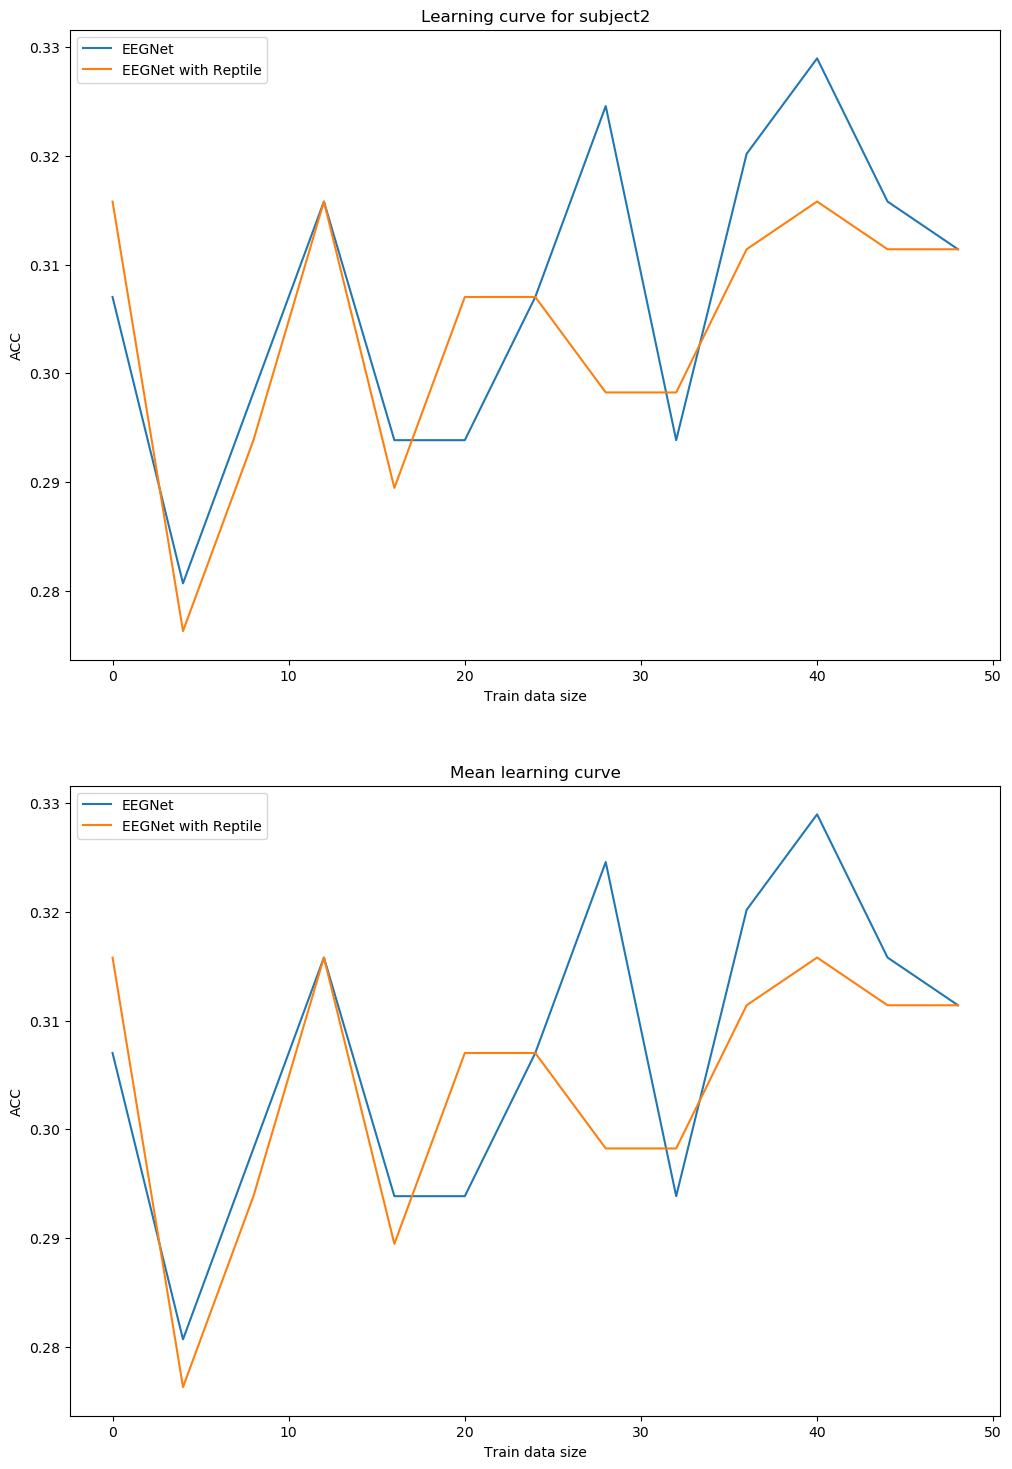

In [2]:
me.aftrain(target_sub=target_sub, model_params=model_params,
           af_params=af_params, dataset_name=dataset_name, iterations=5, logging=True)